In [1]:
import pandas as pd
import seaborn as sns
from glob import glob
import os
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))
import metaprofile_across_regions as mar

In [2]:
# Files
coverage_files = glob('../../../results/Metaprofiles/Lin28aAroundCategoriesOfLinPeaks/**/*_unsmoothed*.tsv')

# Sample annotation
annot = pd.read_csv('../../../data/general/SampleAnnotation.csv', index_col=0)

# Save to
outpath = '../../../results/Metaprofiles/Lin28aAroundCategoriesOfLinPeaks'
os.makedirs(outpath, exist_ok=True)

# Parameters
sw = 20 # Smoothing window

In [3]:
def smoothDf(df, sw):
    cols = [c for c in df.columns.tolist() if c in ['ciMax', 'ciMin', 'mean']]
    df[cols] = df[cols].rolling(sw, center=True,  win_type='triang', axis=0).mean()\
                    .fillna(axis=0, method='ffill')\
                    .fillna(axis=0, method='bfill')
    return df

In [4]:
coverage_files[0]

'../../../results/Metaprofiles/Lin28aAroundCategoriesOfLinPeaks/Shared_LinPeaks_w100_cond-S200A_FCL/coverage_unsmoothed_norm-by_reg.tsv'

In [5]:
# Combine into one table
dfList = []
for f in coverage_files:
    df = pd.read_csv(f, sep='\t')
    df['Peaks'] = f.split('/')[-2].split('_')[0]
    df['Condition'] = f.split('/')[-2].split('cond-')[-1]
    df['Norm'] = f.split('/')[-1].split('norm-')[-1].split('.')[0]
    dfList.append(df)
dfCombined = pd.concat(dfList)

In [6]:
dfCombined.head()

,mean,ciMin,ciMax,Sample,Position,Peaks,Condition,Norm
0,0.005169,0.004655,0.005683,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,-100,Shared,S200A_FCL,by_reg
1,0.005464,0.005088,0.005840,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,-99,Shared,S200A_FCL,by_reg
2,0.005746,0.005203,0.006289,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,-98,Shared,S200A_FCL,by_reg
3,0.005547,0.005024,0.006070,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,-97,Shared,S200A_FCL,by_reg
4,0.005358,0.004928,0.005787,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,-96,Shared,S200A_FCL,by_reg


In [7]:
# Smooth with a desired window
dfCombined = dfCombined.groupby(['Sample', 'Condition', 'Norm', 'Peaks']).apply(smoothDf, sw=sw)

In [8]:
# Annotate samples
dfCombined = dfCombined.merge(annot, on=['Sample', 'Condition'], how='left')
dfCombined.head()

,mean,ciMin,ciMax,Sample,Position,Peaks,Condition,Norm,Protein,Experiment
0,0.006567,0.005717,0.007418,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,-100,Independent,S200A_FCL,by_reg,LIN28A,FLAG-IP LIN28A – merged
1,0.006567,0.005717,0.007418,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,-99,Independent,S200A_FCL,by_reg,LIN28A,FLAG-IP LIN28A – merged
2,0.006567,0.005717,0.007418,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,-98,Independent,S200A_FCL,by_reg,LIN28A,FLAG-IP LIN28A – merged
3,0.006567,0.005717,0.007418,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,-97,Independent,S200A_FCL,by_reg,LIN28A,FLAG-IP LIN28A – merged
4,0.006567,0.005717,0.007418,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,-96,Independent,S200A_FCL,by_reg,LIN28A,FLAG-IP LIN28A – merged


('by_reg', 'Independent')
('by_reg', 'Shared')
('libsize', 'Independent')
('libsize', 'Shared')


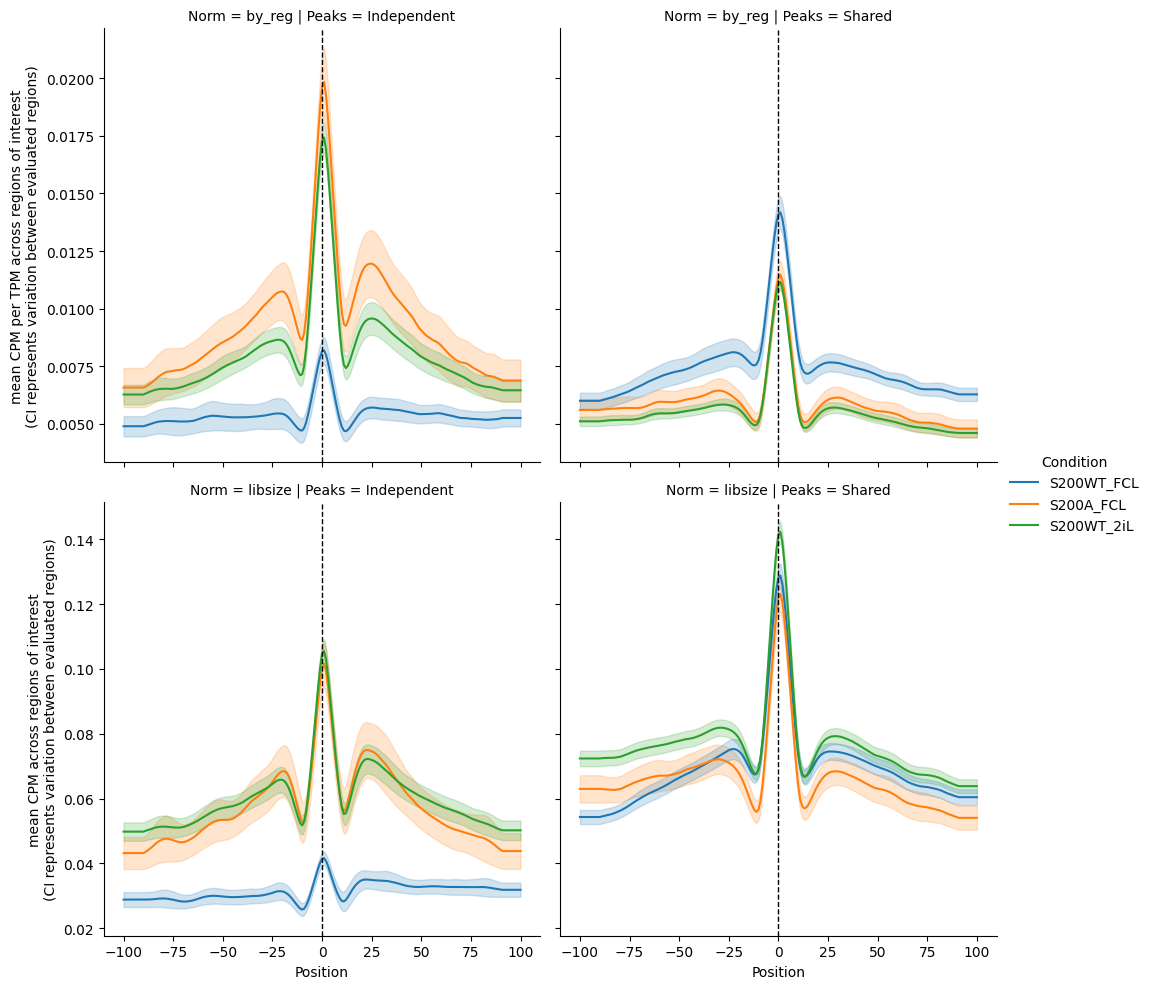

In [9]:
# Plot
dfPlot = dfCombined
hue_order = ['S200WT_FCL', 'S200A_FCL', 'S200WT_2iL']
colorMap = {sample: sns.color_palette('tab10', len(hue_order))[i] for i, sample in enumerate(hue_order)}

g = sns.relplot(
    data=dfPlot, x='Position', y='mean', hue='Condition',
    kind='line', col='Peaks', row='Norm', facet_kws={'sharey': 'row', 'sharex': True},
    hue_order=hue_order, palette=colorMap
    )

for idx, ax in g.axes_dict.items():
    print(idx)
    df = dfPlot.loc[(dfPlot['Norm'] == idx[0]) & (dfPlot['Peaks']==idx[1])]
    ax.axvline(0, color='black', ls='dashed', lw=1)
    for line_ids, dft in df.groupby('Condition'):
        ax.fill_between(dft.Position, dft.ciMin, dft.ciMax, alpha=0.2, color=colorMap[line_ids])
        if idx[0] == 'libsize':
            ax.set_ylabel('mean CPM across regions of interest\n(CI represents variation between evaluated regions)')
        else:
            ax.set_ylabel('mean CPM per TPM across regions of interest\n(CI represents variation between evaluated regions)')
g.fig.savefig(f'{outpath}/LIN28A_around_LIN28APeaks-SharedOrIndependentOfPabp_metaprofiles.pdf', bbox_inches='tight')